# **DataKit Challenge: Producers Direct**

## **Challenge 2: Seasonality (Kenya)** 
## **Part III (LDA Topic Modeling)**

By Conrad Kleykamp

Table of Contents:
- [Executive Summary](#1)
- [Set Up](#2)
- [NLP](#3)
    - [Preprocessing Pipeline](#3.1)
    - [Preprocessing Statistics](#3.2)
- [LDA](#4)
    - [LDA Pipelines](#4.1)
    - [LDA Training](#4.2)
    - [Saving Models](#4.3)
- [Visualizations](#5)     

## **1) Executive Summary**

---

### **Overview**

Relevant Challenge:

- **Challenge 2: Seasonality**

The overarching goal of this project is to identify seasonal patterns (based on temporal data) that may influence the types of questions that farmers ask. Predictive insights may assist farmers by preemptively determining their needs prior to significant weather/climate/seasonal challenges. 

### **Current Project Phase: Latent Dirichlet Allocation (LDA) Topic Modeling (Kenya)**

In my first submission, I identified Kenya as a suitable candidate for seasonal analysis, as it had a large volume of English questions and had a significant temporal range, i.e. 9.76M questions, 77% English, 4.6 years (2017-2022).

In my second submission, I created and stored a new dataframe that was filtered to include only questions from Kenya that were in English. This dataframe was then used to analyze question volume across different temporal categories, i.e. Kenya agricultural season, standard meteorological season, and month. 

In my third submission, I identified the top 15 most frequent words per 1000 questions. These top 15 words were visualized by temporal category.

In this current phase, I applied Latent Dirichlet Allocation (LDA) to uncover latent topics within farmer questions across Kenya's five agricultural seasons. Using NLP processing techniques and unsupervised machine learning, I identified 5 distinct topics per season from 100,000 randomly sampled questions, revealing seasonal patterns in agricultural information needs and enabling targeted support strategies for farmers throughout the year. 

### **Methodology**

- **Dataframe Optimization** (not shown in this notebook)
    - Column selection:
        - Reduced dataset (created in phase 2) from 35 to 12 essential columns, retaining only features required for LDA topic modeling
        - Preserved core question data and streamlined temporal features
        - Reduced memory impact from 10.80 GB to 3.05 GB
    - Data type optimization:
        - Converted object columns to category dtype: question_topic, month_name, kenya_season, standard_season
        - Downcast integer columns: year (int64 --> int16), month (int64 --> int8)
        - Further reduced memory impact from 3.05 GB to 1.09 GB
    - Final optimized dataset (used in this project):
        - 7,511,473 rows x 12 columns, 1.09 GB memory   
- **NLP Preprocessing Pipeline**
    - Converted text to lowercase
    - Removed URLs, email addresses, special characters, numbers
    - Tokenized text
    - Removed stopwords
    - Lemmatized text
    - Filtered out tokens with fewer than 3 characters
    - Filtered out documents with fewer than 3 tokens
    - Final preprocessed corpus: 6,981,271 documents, 250,845 unique tokens
- **LDA Topic Modeling**
    - Seasonal sampling: 100,000 documents randomly sampled per season
    - Dictionary construction: Initial vocabulary filtered using Gensim's filter_extremes
    - Corpus creation: Bag-of-words representation using doc2bow
    - Model training: 5 topics per season, 10 passes, 100 iterations
    - Evaluation: Coherence calculated using C_V metric
    - Visualizations: Word clouds, topic prevalence, coherence   

### **Key Findings**
- **Model Performance**
    - Coherence scores (C_V) ranged from 0.3253 to 0.3701 across seasons
    - Transition (Sep) had the highest coherence; Short Rains (Oct-Dec) had the lowest
    - All seasons demonstrated acceptable coherence (>0.30) for exploratory data analysis, indicating interpretable topics
- **Seasonal Topic Patterns**
    - **Long Rains (Mar-May)**
        - Topic 4 (plant, maize, best, crop...) showed the highest prevalence (38%), reflecting farmer focus on planting maize during the primary planting season
    - **Harvest 1 (Jun-Aug)**
        - Topic 4 (plant, best, tomato, maize...) showed the highest prevalence (39%), indicating continued maize interest during the first harvest period
        - Inclusion of 'tomato' indicates harvest of this crop; Consistent with the temporal word frequency findings in my third submission
    - **Transition (Sep)**
        - Topic 2 (maize, plant, best, crop...) showed the highest prevalence (47%), suggesting continued interest in maize heading into the Short Rains/secondary planting season
    - **Short Rains (Oct-Dec)**
        - Topic 0 (maize, plant, best, crop...) showed the highest prevalence (0.42%); Dominant interest in maize during the Short Rains/secondary planting season is consistent with the findings in my third submission
    - **Harvest 2 (Jan-Feb)**
        - Topic 3 (plant, maize, best, crop...) showed the highest prevalence (0.35%)  
- **Livestock vs. Crop Balance**
    - Livestock topics (dairy, cow, cattle, milk, goat, chicken, egg) remained relatively stable across seasons, but had much lower prevalence (~20) compared to crop/maize related topics (>30%)
    - Maize-related topics dominated across agricultural season, further cementing its year-round significance  

### **Next Steps** (With sufficient time)
- Apply trained seasonal models to full dataset to analyze topic distribution trends over time (2017-2022)
- Develop predictive framework to anticipate farmer information needs based on upcoming season and historical patterns


## **2) Set Up**

---

In [24]:
# Loading in necessary libraries and packages

# Fundamental libraries
import numpy as np 
import pandas as pd 
from collections import Counter

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

# Regex
import re

# NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Gensim (LDA)
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# LDA viz
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [6]:
# Loading in the data (optimized, see Methodology)
print("Loading data...")
df = pd.read_parquet('/kaggle/input/kenya-lda/kenya_lda.parquet')
print(f"Loaded {len(df):,} rows\n")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

Loading data...
Loaded 7,511,473 rows

Memory: 1.09 GB


## **3) NLP**

---

### **3.1) Preprocessing Pipeline**

In [4]:
# Set run == 1 if preprocessing for the first time, otherwise set to 0 to load existing preprocseed data
run = 0

if run == 1:
    print("\nRun flag = 1: Executing preprocessing pipeline...")

    # Initializing lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Loading stop words
    print("\nLoading stop words...")
    stop_words = set(stopwords.words('english'))
    
    # Adding custom agricultural/platform-specific stop words
    custom_stop_words = {
    }
    stop_words.update(custom_stop_words)
    
    print(f"Total stop words: {len(stop_words)} (NLTK + custom)")
    
    # Preprocessing function
    def preprocess_text(text):
        """
        Complete NLP preprocessing pipeline for LDA
        
        Steps:
        1. Convert to lowercase
        2. Remove URLs, emails, and special characters
        3. Remove numbers
        4. Tokenize
        5. Remove stop words
        6. Lemmatize
        7. Filter short words (< 3 characters)
        
        Parameters:
        - text: raw question text
        
        Returns:
        - list of preprocessed tokens
        """
        if pd.isna(text):
            return []
        
        # Converting to lowercase
        text = text.lower()
    
        # Removing URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
        # Removing email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Removing special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenizing using NLTK
        tokens = word_tokenize(text)
        
        # Removing stop words and short words, then lemmatizing
        processed_tokens = [
            lemmatizer.lemmatize(token)
            for token in tokens
            if token not in stop_words and len(token) >= 3
        ]
        
        return processed_tokens
    
    # Applying preprocessing
    print("\nApplying preprocessing pipeline to all questions...")
    
    # Processing in chunks for memory efficiency and progress tracking
    chunk_size = 100000
    n_chunks = int(np.ceil(len(df) / chunk_size))
    
    processed_tokens_list = []
    
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))
        
        print(f"Processing chunk {i+1}/{n_chunks} (rows {start_idx:,} to {end_idx:,})...", end='\r')
        
        chunk = df.iloc[start_idx:end_idx]['question_content']
        chunk_processed = chunk.apply(preprocess_text)
        processed_tokens_list.extend(chunk_processed.tolist())
    
    print(f"\nPreprocessing complete!{' '*50}")

    # Adding processed tokens to dataframe
    df_pre = df.copy()
    df_pre['processed_tokens'] = processed_tokens_list

    # Saving preprocessed data
    print("\nSaving preprocessed data...")
    output_path = 'kenya_lda_preprocessed.parquet'
    df_pre.to_parquet(output_path, compression='snappy', index=False)
    print(f"Saved: {output_path}")

else:
    print("\nRun flag = 0: Loading existing preprocessed data...")
    
    # Loading preprocessed data
    preprocessed_path = '/kaggle/input/kenya-lda-preprocessed/kenya_lda_preprocessed.parquet'
    df_pre = pd.read_parquet(preprocessed_path)
    print(f"Loaded: {preprocessed_path}")
    print(f"  Rows: {len(df_pre):,}")
    print(f"  Columns: {len(df_pre.columns)}")

print("\nPreprocessed data ready!")


Run flag = 0: Loading existing preprocessed data...
Loaded: /kaggle/input/kenya-lda-preprocessed/kenya_lda_preprocessed.parquet
  Rows: 6,981,271
  Columns: 14

Preprocessed data ready!


### **3.2) Preprocessing Statistics**

In [7]:
# Calculating statistics on preprocessed data
df_pre['token_count'] = df_pre['processed_tokens'].apply(len)

print(f"\nToken statistics:")
print(f"  Original documents: {len(df):,}")
print(f"  Preprocessed documents: {len(df_pre):,}")
print(f"  Documents with 0 tokens: {(df_pre['token_count'] == 0).sum():,} ({(df_pre['token_count'] == 0).sum()/len(df_pre)*100:.2f}%)")
print(f"  Mean tokens per document: {df_pre['token_count'].mean():.1f}")
print(f"  Median tokens per document: {df_pre['token_count'].median():.1f}")
print(f"  Min tokens: {df_pre['token_count'].min()}")
print(f"  Max tokens: {df_pre['token_count'].max()}")

# Filtering out documents with too few tokens
min_tokens = 3  # Minimum tokens for meaningful topic analysis
print(f"\nFiltering documents with < {min_tokens} tokens...")
df_filtered = df_pre[df_pre['token_count'] >= min_tokens].copy()

# Comparison with original
print(f"\nOverall preprocessing impact:")
print(f"  Started with: {len(df):,} documents")
print(f"  After preprocessing: {len(df_pre):,} documents")
print(f"  Total removed: {len(df) - len(df_filtered):,} ({(len(df) - len(df_filtered))/len(df)*100:.2f}%)")

# Vocabulary size
all_tokens = [token for tokens in df_filtered['processed_tokens'] for token in tokens]
vocabulary = set(all_tokens)
print(f"\nVocabulary size: {len(vocabulary):,} unique tokens")
print(f"Total tokens: {len(all_tokens):,}")

# Most common tokens
from collections import Counter
token_freq = Counter(all_tokens)
print(f"\nTop 20 most frequent tokens:")
for i, (token, count) in enumerate(token_freq.most_common(20), 1):
    print(f"  {i:2d}. {token:15s}: {count:,}")


Token statistics:
  Original documents: 7,511,473
  Preprocessed documents: 6,981,271
  Documents with 0 tokens: 0 (0.00%)
  Mean tokens per document: 6.2
  Median tokens per document: 5.0
  Min tokens: 3
  Max tokens: 71

Filtering documents with < 3 tokens...

Overall preprocessing impact:
  Started with: 7,511,473 documents
  After preprocessing: 6,981,271 documents
  Total removed: 530,202 (7.06%)

Vocabulary size: 250,845 unique tokens
Total tokens: 43,571,148

Top 20 most frequent tokens:
   1. plant          : 1,189,407
   2. maize          : 1,066,386
   3. best           : 870,896
   4. cow            : 759,779
   5. crop           : 472,083
   6. type           : 425,642
   7. tomato         : 401,493
   8. get            : 362,987
   9. bean           : 349,958
  10. use            : 343,277
  11. one            : 337,263
  12. many           : 328,678
  13. good           : 305,477
  14. chicken        : 283,703
  15. seed           : 271,432
  16. chick          : 267,300

## **4) LDA**

---

### **4.1) LDA Pipelines**

In [17]:
# LDA seasonal pipeline
def train_seasonal_lda(df_filtered, seasons, num_topics=5, sample_size=100000):
    """
    Train LDA for multiple agricultural seasons
    
    Parameters:
    -----------
    df_filtered : DataFrame with 'processed_tokens' and 'kenya_season'
    seasons : List of season names to analyze
    num_topics : Number of topics per season (default: 5)
    sample_size : Documents to sample per season (default: 100k)
    
    Returns:
    --------
    results : Dict with models, corpus, dictionary, coherence for each season
    """
    
    results = {}
    
    for season_name in seasons:
        print(f"\n{'='*80}")
        print(f"SEASON: {season_name.upper()}")
        print(f"{'='*80}")
        
        # Filtering to season
        df_season = df_filtered[df_filtered['kenya_season'] == season_name].copy()
        print(f"Season documents: {len(df_season):,}")
        
        # Sampling
        n_sample = min(sample_size, len(df_season))
        df_sample = df_season.sample(n=n_sample, random_state=42)
        print(f"Sampled: {len(df_sample):,} documents")
        
        # Building corpus
        documents = df_sample['processed_tokens'].tolist()
        dictionary = corpora.Dictionary(documents)
        print(f"Initial vocab: {len(dictionary):,} tokens", end=" -> ")
        
        dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)
        print(f"{len(dictionary):,} after filtering")
        
        corpus = [dictionary.doc2bow(doc) for doc in documents]
        
        # Training LDA
        print(f"Training {num_topics} topics...")
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=10,
            iterations=100,
            random_state=42,
            alpha='auto'
        )
        
        # Coherence
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=documents,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = coherence_model.get_coherence()
        print(f"Coherence (C_V): {coherence:.4f}")
        
        # Displaying topics
        print(f"\nTop 10 Words per Topic:")
        print("-" * 80)
        for idx, topic in lda_model.print_topics(num_words=10):
            print(f"\nTopic {idx}:")
            words = [w.split('*')[1].strip('"') for w in topic.split(' + ')]
            weights = [float(w.split('*')[0]) for w in topic.split(' + ')]
            for word, weight in zip(words, weights):
                print(f"  {weight:.3f} - {word}")
        
        # Storing results
        results[season_name] = {
            'model': lda_model,
            'corpus': corpus,
            'dictionary': dictionary,
            'coherence': coherence,
            'sample': df_sample
        }
    
    return results

In [25]:
# LDA viz pipelines
def visualize_all_seasons_wordclouds(results, num_topics=5):
    """
    Stacked word clouds for all seasons
    """
    
    seasons = list(results.keys())
    n_seasons = len(seasons)
    
    fig, axes = plt.subplots(n_seasons, num_topics, figsize=(20, 4*n_seasons))
    
    for season_idx, season_name in enumerate(seasons):
        lda_model = results[season_name]['model']
        
        for topic_idx in range(num_topics):
            topic_words = dict(lda_model.show_topic(topic_idx, topn=30))
            
            wc = WordCloud(
                width=400,
                height=300,
                background_color='white',
                colormap='viridis',
                relative_scaling=0.5
            ).generate_from_frequencies(topic_words)
            
            ax = axes[season_idx, topic_idx] if n_seasons > 1 else axes[topic_idx]
            ax.imshow(wc, interpolation='bilinear')
            ax.set_title(f'{season_name}\nTopic {topic_idx}', fontsize=10, fontweight='bold')
            ax.axis('off')
    
    plt.suptitle('Topic Word Clouds by Season', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('/kaggle/working/all_seasons_wordclouds.png', dpi=300, bbox_inches='tight')
    plt.show()


def visualize_all_seasons_prevalence(results):
    """
    Stacked topic prevalence for all seasons
    """
    
    seasons = list(results.keys())
    n_seasons = len(seasons)
    num_topics = results[seasons[0]]['model'].num_topics
    
    # Setting seaborn color palette
    colors = sns.color_palette('Set2', num_topics)
    
    fig, axes = plt.subplots(n_seasons, 1, figsize=(12, 4*n_seasons))
    if n_seasons == 1:
        axes = [axes]
    
    for season_idx, season_name in enumerate(seasons):
        lda_model = results[season_name]['model']
        corpus = results[season_name]['corpus']
        
        # Calculating topic weights
        topic_weights = np.zeros(num_topics)
        for doc in corpus:
            topic_dist = lda_model.get_document_topics(doc, minimum_probability=0)
            for topic_id, weight in topic_dist:
                topic_weights[topic_id] += weight
        topic_weights /= len(corpus)
        
        # Plotting
        topics = [f'Topic {i}' for i in range(num_topics)]
        axes[season_idx].bar(topics, topic_weights, color=colors)
        axes[season_idx].set_ylabel('Prevalence', fontsize=11)
        axes[season_idx].set_title(season_name, fontsize=12, fontweight='bold')
        axes[season_idx].grid(axis='y', alpha=0.3)
        axes[season_idx].set_ylim(0, max(topic_weights) * 1.1)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/all_seasons_prevalence.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_coherence_comparison(results):
    """
    Bar chart comparing coherence across seasons
    """
    
    seasons = list(results.keys())
    coherences = [results[season]['coherence'] for season in seasons]
    
    # Setting seaborn color palette
    colors = sns.color_palette('Set2', len(seasons))
    
    plt.figure(figsize=(10, 6))
    plt.bar(seasons, coherences, color=colors)
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Coherence (C_V)', fontsize=12)
    plt.title('LDA Coherence by Season', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(coherences) * 1.1)
    plt.grid(axis='y', alpha=0.3)
    
    # Adding value labels on bars
    for i, (season, coh) in enumerate(zip(seasons, coherences)):
        plt.text(i, coh + 0.01, f'{coh:.4f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/coherence_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

### **4.2) Training LDA**

In [20]:
# Define seasons to analyze
all_seasons = [
    'Long Rains (Mar-May)',
    'Harvest 1 (Jun-Aug)',
    'Transition (Sep)',
    'Short Rains (Oct-Dec)',
    'Harvest 2 (Jan-Feb)'
]

# Training LDA for all seasons
results = train_seasonal_lda(
    df_filtered,
    seasons=all_seasons,
    num_topics=5,
    sample_size=100000
)


SEASON: LONG RAINS (MAR-MAY)
Season documents: 1,606,175
Sampled: 100,000 documents
Initial vocab: 33,412 tokens -> 6,206 after filtering
Training 5 topics...
Coherence (C_V): 0.3673

Top 10 Words per Topic:
--------------------------------------------------------------------------------

Topic 0:
  0.062 - use
  0.037 - qwhat
  0.034 - control
  0.027 - cause
  0.026 - used
  0.025 - disease
  0.021 - chemical
  0.020 - livestock
  0.017 - farm
  0.017 - spray

Topic 1:
  0.084 - cow
  0.031 - take
  0.030 - chick
  0.029 - long
  0.026 - hen
  0.025 - feed
  0.025 - give
  0.023 - qhow
  0.020 - chicken
  0.019 - month

Topic 2:
  0.061 - dairy
  0.057 - asks
  0.053 - milk
  0.041 - reply
  0.039 - followed
  0.036 - response
  0.035 - breed
  0.030 - production
  0.028 - produce
  0.026 - cattle

Topic 3:
  0.054 - get
  0.045 - one
  0.033 - want
  0.033 - many
  0.026 - farmer
  0.025 - poultry
  0.022 - start
  0.020 - need
  0.020 - much
  0.018 - farming

Topic 4:
  0.084 - p

### **4.3) Saving Models**

In [27]:
# Save all models function
def save_all_models(results):
    """
    Save all trained models
    """
    
    print("\nSaving models...")
    for season_name in results.keys():
        safe_name = season_name.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")
        
        results[season_name]['model'].save(f'/kaggle/working/lda_{safe_name}.model')
        results[season_name]['dictionary'].save(f'/kaggle/working/dict_{safe_name}.dict')
        
        print(f"  Saved: lda_{safe_name}.model, dict_{safe_name}.dict")

# Applying function
save_all_models(results)


Saving models...
  Saved: lda_Long_Rains_Mar_May.model, dict_Long_Rains_Mar_May.dict
  Saved: lda_Harvest_1_Jun_Aug.model, dict_Harvest_1_Jun_Aug.dict
  Saved: lda_Transition_Sep.model, dict_Transition_Sep.dict
  Saved: lda_Short_Rains_Oct_Dec.model, dict_Short_Rains_Oct_Dec.dict
  Saved: lda_Harvest_2_Jan_Feb.model, dict_Harvest_2_Jan_Feb.dict


## **5) Visualizations**

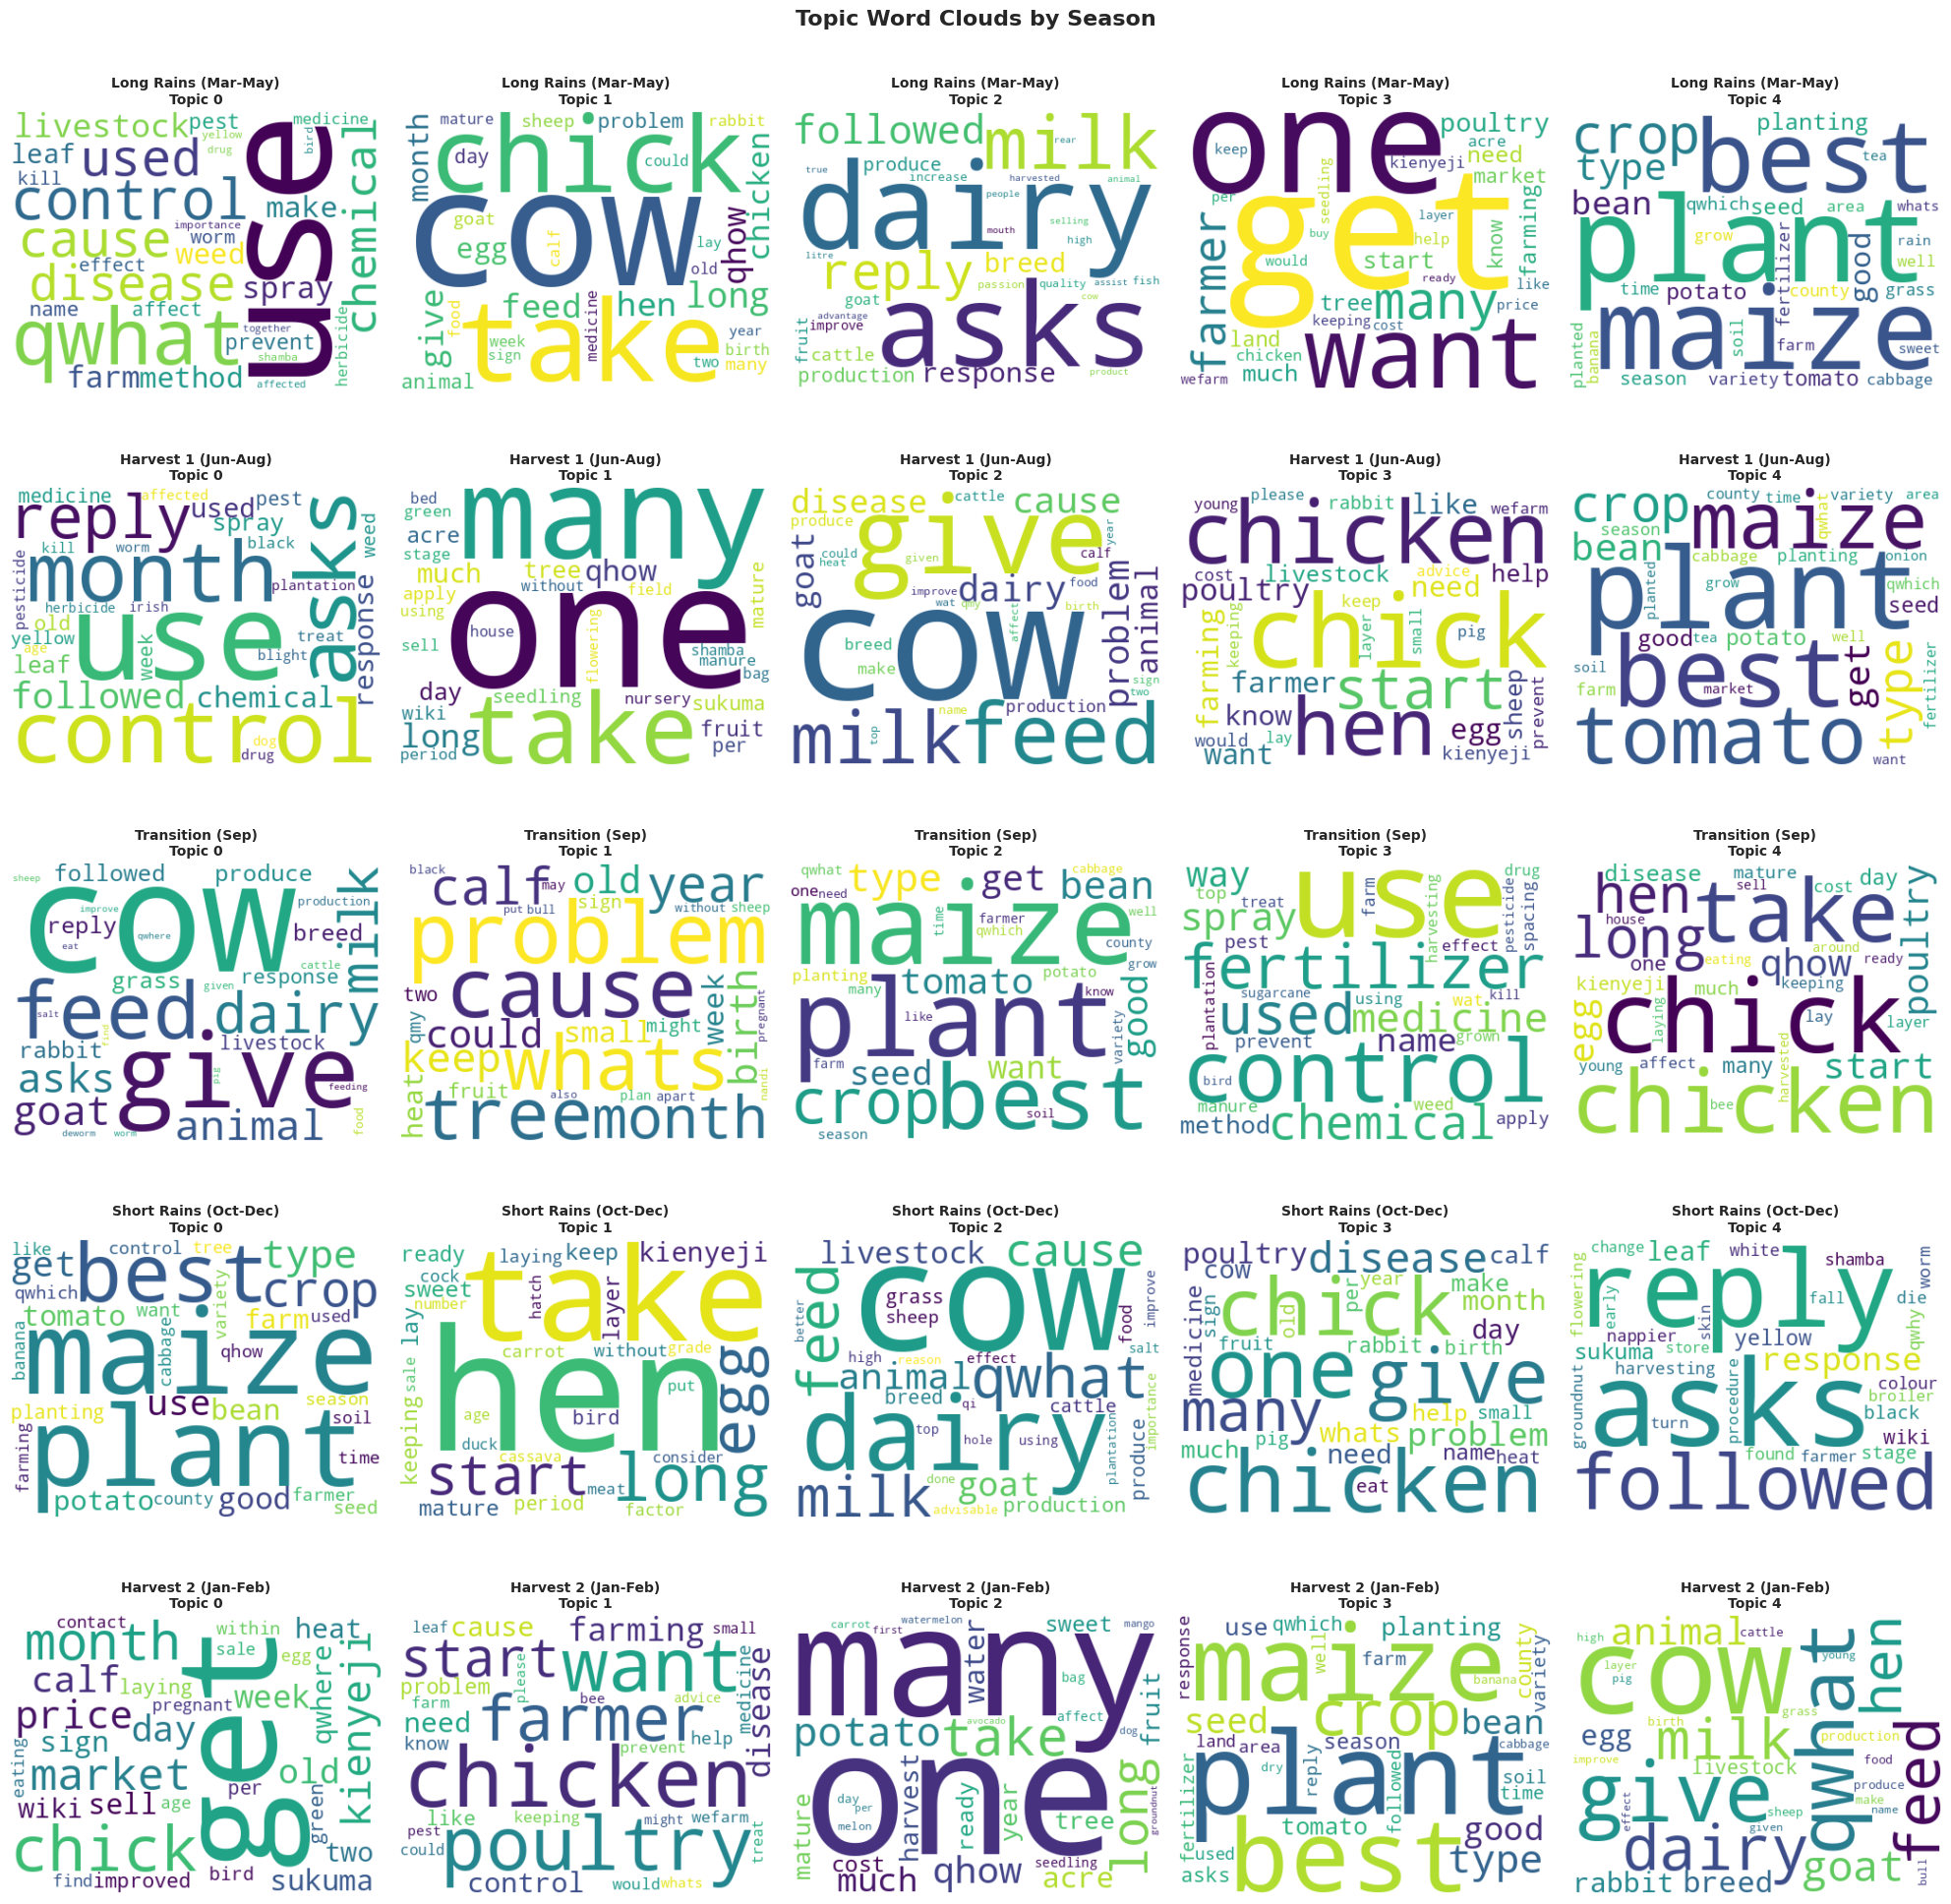

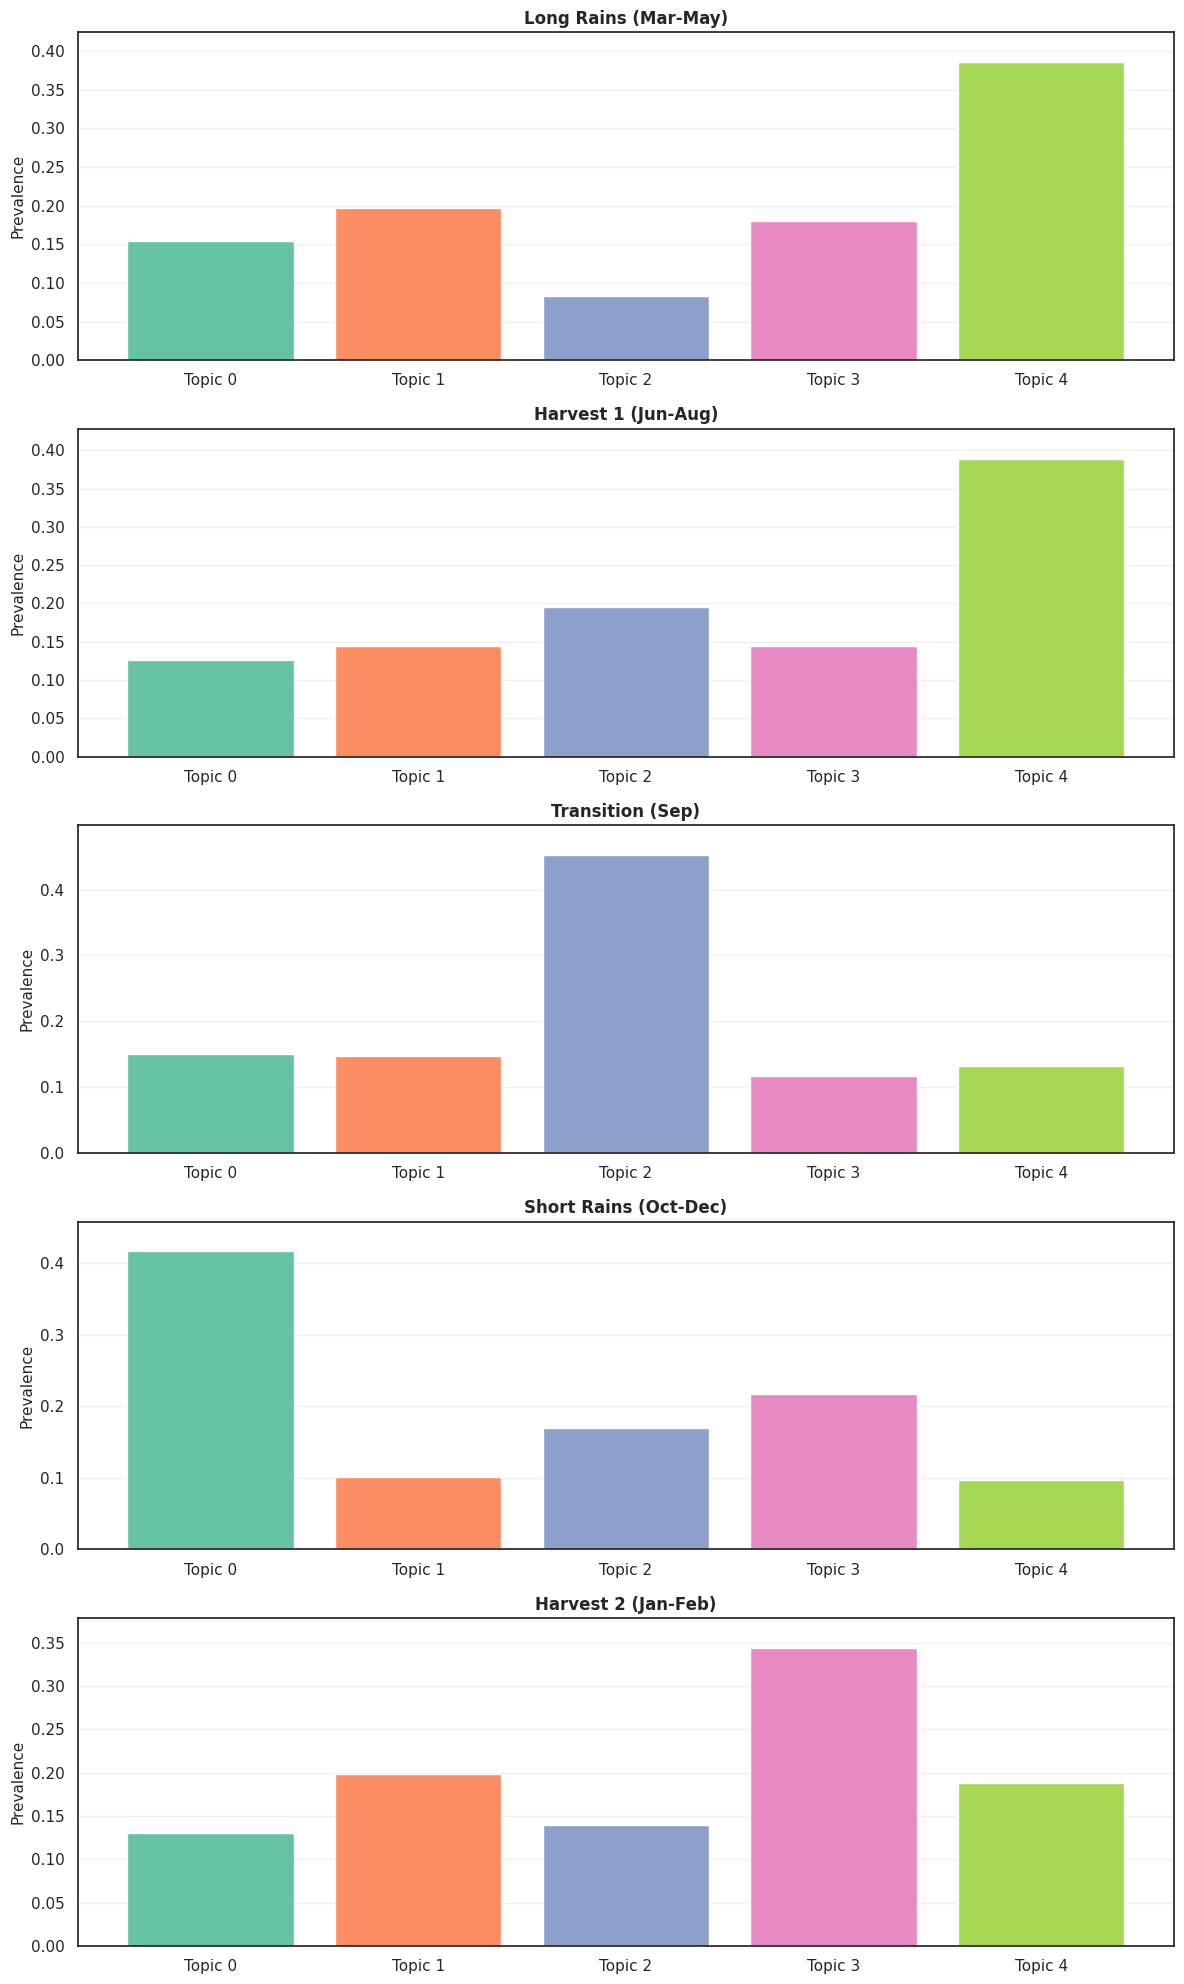

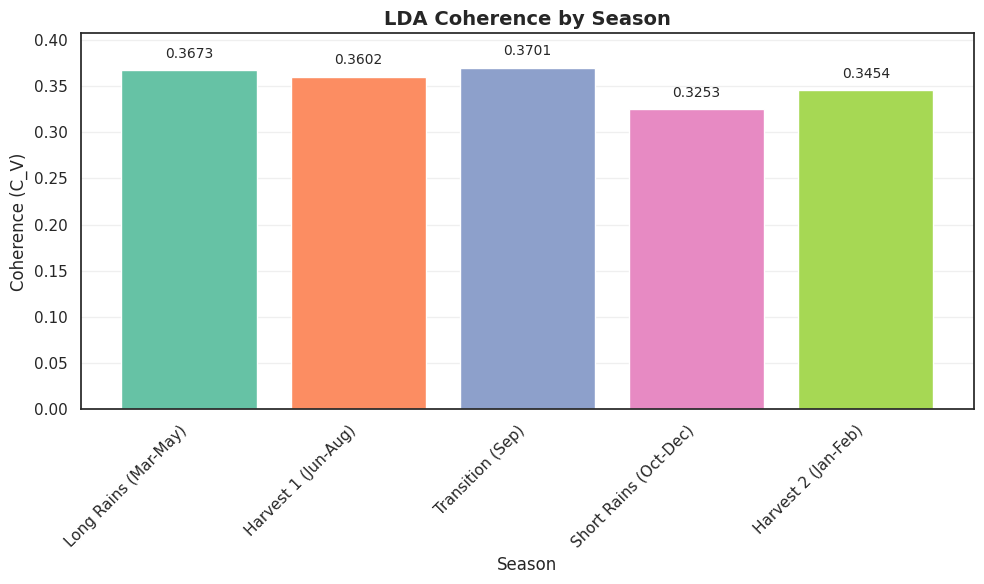

In [26]:
# Creating visualizations using visualization pipeline
visualize_all_seasons_wordclouds(results)
visualize_all_seasons_prevalence(results)
plot_coherence_comparison(results)